In [3]:
import cv2
import json
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path
from openslide import OpenSlide
from tqdm.notebook import tqdm
%matplotlib inline

output_dir = Path('/mnt/hpc/pathology/hovernet_output/isala/core')
roi_dir = Path('/mnt/hpc/pathology/annotations/isala/core')
slide_r = Path('/mnt/hpc/pathology/metastasis/isala')

df = pd.DataFrame(columns=['tils_per_area'])

for file in tqdm(list(roi_dir.iterdir())):
    with open(output_dir / (file.stem + '.json'), 'r') as f:
        annotations = json.load(f)

    count = 0
    for annotation in annotations:
        if annotation['properties']['classification']['name'] == 'inflam':
            count += 1
            

    roi_file = roi_dir / (file.stem + '.xml')

    with open(roi_file, 'r') as f:
        xml_file = ET.parse(f)

    rois = []
    for annotation in xml_file.getroot()[0]:
        roi = []
        for coordinate in annotation[0]:
            roi.append([coordinate.attrib['X'], coordinate.attrib['Y']])
        rois.append(np.array(roi).astype(float).astype(int))


    slide = OpenSlide(str(slide_r / (file.stem + '.ndpi')))
    voxel_size = float(slide.properties['openslide.mpp-x']) * float(slide.properties['openslide.mpp-y']) 

    total_area = 0

    factor = 10

    for roi in rois:
        origin = roi.min(axis=0)
        width = int((roi[:,0].max() - origin[0]) / factor)
        height = int((roi[:,1].max() - origin[1]) / factor)

        area = np.zeros((width, height))
        try:
            cv2.fillPoly(area, [((roi - origin) / factor).astype(int)], 1)
        except Exception as e:
            print(e)
            print(area)
            continue

        total_area += area.sum() * (factor ** 2) * voxel_size

    print(total_area)
    
    df.loc[file.stem] = count / total_area

  0%|          | 0/56 [00:00<?, ?it/s]

177859.632282142
15319772.260546815
77001861.5157683
41401515.76983046
924358.6568902817
4070441.104483632
12035349.847064808
18407837.93585849
117381593.14096838
OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'fillPoly'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'

[]
142493049.589624
40088622.78848686
93263533.24770091
1182303.7307757004
50634102.34602857
57903808.37964524
11355194.198245846
10306396.142616812
11543366.984110886
82911198.1345906
22527282.369994476
867884.6309437567
28275016.310210124
39018971.24044405
OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'fillPoly'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'

[]
OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'fillPoly'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with c

<AxesSubplot: >

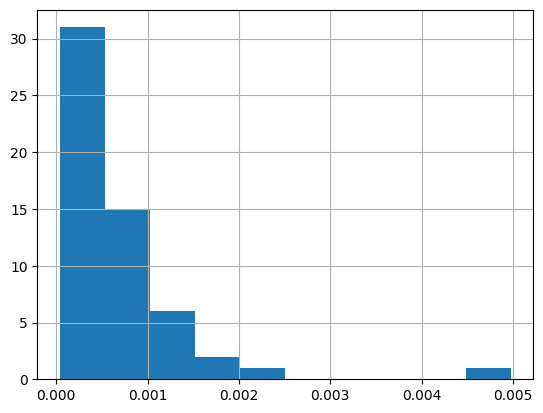

In [4]:
df.tils_per_area.hist()

In [41]:
manual  = pd.read_csv('/mnt/c/Users/user/Downloads/PREMIUM_TILS_Isala_METASTASIS_22_12_12_11.csv', sep='\t')
clark = manual[manual.Question == 'Clark score'].groupby('Image Name').Answer.first()
mia = manual[manual.Question == 'MIA score'].groupby('Image Name').Answer.first()
salgado = manual[manual.Question == "Salgado 'stromal'"].groupby('Image Name').Answer.first()
clark = clark.to_frame().rename(columns={'Answer':'clark'})
mia = mia.to_frame().rename(columns={'Answer':'mia'})
salgado = salgado.to_frame().rename(columns={'Answer':'salgado'})
manual = clark.join(mia).join(salgado)

In [42]:
df = manual.join(df)

ValueError: columns overlap but no suffix specified: Index(['salgado'], dtype='object')

In [34]:
df

,clark,mia,salgado,tils_per_area
Image Name,,,,
PREM-IS-006_48d913dbed I3 HE1 - 2022-03-24 19.36.01,Absent A - no lymphocytes,grade 0 - TIL absent,0%,0.000258
PREM-IS-075_6d2039bb4d I3 HE1 - 2022-03-24 19.57.33,Absent A - no lymphocytes,grade 0 - TIL absent,0%,NaN
PREM-IS-136_15d47281a9 I1 HE2 - 2022-03-25 13.33.43,Absent A - no lymphocytes,grade 0 - TIL absent,0%,NaN
PREM-IS-134_988953567a I1 HE1 - 2022-03-25 13.31.06,Absent A - no lymphocytes,grade 0 - TIL absent,0%,0.000947
PREM-IS-137_6d9eb60430 I1 HE1 - 2022-03-25 13.37.29,Absent A - no lymphocytes,grade 0 - TIL absent,0%,NaN
...,...,...,...,...
PREM-IS-142_abcbec20c1 II4 HE1 - 2022-03-25 14.54.17,Brisk diffuse,grade 3 - moderate or marked diffuse infiltrate,90%,NaN
PREM-IS-109_2488bb4da7 I2 HE1 - 2022-03-25 13.42.31,Brisk diffuse,grade 3 - moderate or marked diffuse infiltrate,90%,NaN
PREM-IS-009_412623daa8 II30 HE1 - 2022-03-24 19.19.23,Brisk diffuse,grade 3 - moderate or marked diffuse infiltrate,95%,NaN


In [38]:
df = df[~df.apply(lambda x: x.apply(lambda x: x == 'NA -> geisoleerde tumorcellen')).any(axis=1)]

In [40]:
import seaborn as sn
import matplotlib.pyplot as plt

df = df.sort_values(by='salgado', key=lambda x: x.apply(lambda x: int(x.split('%')[0])))
p = sn.swarmplot(df, x='tils_per_area', y='salgado', orient='h')
plt.xticks(rotation=90)
plt.show()

ValueError: Could not interpret value `tils_per_area` for parameter `x`

In [19]:
(~df.tils_per_area.isna()).sum()

56